In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader as dl
from torch_geometric.nn import GCNConv, BatchNorm, global_max_pool
from scipy.spatial import Delaunay
import networkx as nx
from torch_geometric.utils import to_networkx
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns

In [2]:
def shuffle_and_sync_data(features_gcn, labels_gcn, filenames_gcn, features_cnn, labels_cnn, filenames_cnn, random_state=None):
    np.random.seed(random_state)
    indices = np.random.permutation(len(filenames_gcn))
    return (features_gcn[indices], labels_gcn[indices], filenames_gcn[indices],
            features_cnn[indices], labels_cnn[indices], filenames_cnn[indices])

In [3]:
train_df = pd.read_csv("/home/muhammadariz/Dataset/V3b/TrainEngagement_v3b.csv")
val_df = pd.read_csv("/home/muhammadariz/Dataset/V3b/ValEngagement_v3b.csv")
test_df = pd.read_csv("/home/muhammadariz/Dataset/V3b/TestEngagement_v3b.csv")

In [4]:
train_au_df = pd.read_csv('/home/muhammadariz/Dataset/blendshape/TrainEngagement_blendshape.csv')
val_au_df = pd.read_csv('/home/muhammadariz/Dataset/blendshape/ValEngagement_blendshape.csv')
test_au_df = pd.read_csv('/home/muhammadariz/Dataset/blendshape/TestEngagement_blendshape.csv')

In [5]:
#GCN data
train_filenames = train_df['file_name'].str.split('.').str[0].values
train_labels = train_df['labels'].values
train_df = train_df.drop(columns=['file_name', 'labels']).values

val_filenames = val_df['file_name'].str.split('.').str[0].values
val_labels = val_df['labels'].values
val_df = val_df.drop(columns=['file_name', 'labels']).values

test_filenames = test_df['file_name'].str.split('.').str[0].values
test_labels = test_df['labels'].values
test_df = test_df.drop(columns=['file_name', 'labels']).values

In [6]:
#CNN data
train_au_filenames = train_au_df['file_name'].str.split('.').str[0].values
train_au_features = train_au_df.drop(columns=['file_name']).values

val_au_filenames = val_au_df['file_name'].str.split('.').str[0].values
val_au_features = val_au_df.drop(columns=['file_name']).values

test_au_filenames = test_au_df['file_name'].str.split('.').str[0].values
test_au_features = test_au_df.drop(columns=['file_name']).values

In [7]:
(train_df, train_labels, train_filenames, 
 train_au_features, train_au_labels, train_au_filenames) = shuffle_and_sync_data(
    train_df, train_labels, train_filenames,
    train_au_features, train_labels, train_au_filenames,
    random_state=42)

(val_df, val_labels, val_filenames, 
 val_au_features, val_au_labels, val_au_filenames) = shuffle_and_sync_data(
    val_df, val_labels, val_filenames,
    val_au_features, val_labels, val_au_filenames,
    random_state=42)

(test_df, test_labels, test_filenames, 
 test_au_features, test_au_labels, test_au_filenames) = shuffle_and_sync_data(
    test_df, test_labels, test_filenames,
    test_au_features, test_labels, test_au_filenames,
    random_state=42)

In [8]:
minmax_scaler = MinMaxScaler()
train_df = minmax_scaler.fit_transform(train_df)
val_df = minmax_scaler.transform(val_df)
test_df = minmax_scaler.transform(test_df)

In [9]:
train_labels = torch.tensor(train_labels, dtype=torch.long)
val_labels = torch.tensor(val_labels, dtype=torch.long)
test_labels = torch.tensor(test_labels, dtype=torch.long)

In [10]:
def create_delaunay_graph_data(X, y):
    num_nodes = X.shape[1] // 2
    data_list = []

    for i in range(X.shape[0]):
        node_features = torch.tensor(X[i].reshape(num_nodes, 2), dtype=torch.float)
        points = node_features.numpy()  # Use x and y for Delaunay triangulation
        tri = Delaunay(points)

#         y_tensor = torch.tensor([y[i]], dtype=torch.long)
        y_tensor = y[i]
        edges = set()
        for simplex in tri.simplices:
            for j in range(3):
                for k in range(j + 1, 3):
                    edges.add((simplex[j], simplex[k]))
                    edges.add((simplex[k], simplex[j]))
        
        edge_index = torch.tensor(list(edges), dtype=torch.long).t().contiguous()
        data_list.append(Data(x=node_features, edge_index=edge_index, y=y_tensor))
    
    return data_list

In [11]:
train_data = create_delaunay_graph_data(train_df, train_labels)
val_data = create_delaunay_graph_data(val_df, val_labels)
test_data = create_delaunay_graph_data(test_df, test_labels)

In [12]:
for i, data in enumerate(train_data):
    data.filename = train_filenames[i]

for i, data in enumerate(val_data):
    data.filename = val_filenames[i]
    
for i, data in enumerate(test_data):
    data.filename = test_filenames[i]

In [13]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=False)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [14]:
scaler = MinMaxScaler()
train_au_features = scaler.fit_transform(train_au_features)
val_au_features = scaler.transform(val_au_features)
test_au_features = scaler.transform(test_au_features)

In [15]:
train_au_features = torch.tensor(train_au_features, dtype=torch.float32).unsqueeze(1).unsqueeze(2)
val_au_features = torch.tensor(val_au_features, dtype=torch.float32).unsqueeze(1).unsqueeze(2)
test_au_features = torch.tensor(test_au_features, dtype=torch.float32).unsqueeze(1).unsqueeze(2)


In [16]:
class CustomTensorDataset(torch.utils.data.Dataset):
    def __init__(self, tensors, filenames):
        self.tensors = tensors
        self.filenames = filenames

    def __getitem__(self, index):
        return tuple(tensor[index] for tensor in self.tensors) + (self.filenames[index],)

    def __len__(self):
        return len(self.tensors[0])

# Prepare datasets with filenames
train_au_dataset = CustomTensorDataset((train_au_features, train_labels), train_au_filenames)
val_au_dataset = CustomTensorDataset((val_au_features, val_labels), val_au_filenames)
test_au_dataset = CustomTensorDataset((test_au_features, test_labels), test_au_filenames)

In [17]:
train_au_loader = dl(train_au_dataset, batch_size=32, shuffle=False)
val_au_loader = dl(val_au_dataset, batch_size=32, shuffle=False)
test_au_loader = dl(test_au_dataset, batch_size=32, shuffle=False)

In [18]:
# class LDAMLoss(nn.Module):
#     def __init__(self, cls_num_list, max_m=0.5, weight=None, s=30):
#         super(LDAMLoss, self).__init__()
#         m_list = 1.0 / np.sqrt(np.sqrt(cls_num_list))
#         m_list = m_list * (max_m / np.max(m_list))
#         m_list = torch.cuda.FloatTensor(m_list)
#         self.m_list = m_list
#         assert s > 0
#         self.s = s
#         self.weight = weight

#     def forward(self, x, target):
#         index = torch.zeros_like(x, dtype=torch.uint8)
#         index.scatter_(1, target.data.view(-1, 1), 1)
        
#         index_float = index.type(torch.cuda.FloatTensor)
#         batch_m = torch.matmul(self.m_list[None, :], index_float.transpose(0,1))
#         batch_m = batch_m.view((-1, 1))
#         x_m = x - batch_m
    
#         output = torch.where(index, x_m, x)
#         return F.cross_entropy(self.s * output, target, weight=self.weight)

In [19]:
# class LDAMLoss(nn.Module):
#     def __init__(self, cls_num_list, max_m=0.5, s=30):
#         super(LDAMLoss, self).__init__()
#         m_list = 1.0 / np.sqrt(np.sqrt(cls_num_list))
#         m_list = m_list * (max_m / np.max(m_list))
#         self.m_list = torch.cuda.FloatTensor(m_list)
#         assert s > 0
#         self.s = s

#     def forward(self, x, target, weight):
#         index = torch.zeros_like(x, dtype=torch.uint8)
#         index.scatter_(1, target.data.view(-1, 1), 1)
        
#         index_float = index.type(torch.cuda.FloatTensor)
#         batch_m = torch.matmul(self.m_list[None, :], index_float.transpose(0, 1))
#         batch_m = batch_m.view((-1, 1))
#         x_m = x - batch_m
    
#         output = torch.where(index, x_m, x)
#         return F.cross_entropy(self.s * output, target, weight=weight)

In [20]:
# class SimpleGNN(torch.nn.Module):
#     def __init__(self, num_node_features, hidden_dim, num_classes):
#         super(SimpleGNN, self).__init__()
#         self.conv1 = GCNConv(num_node_features, hidden_dim)
#         self.bn1 = nn.BatchNorm1d(hidden_dim)
#         self.conv2 = GCNConv(hidden_dim, hidden_dim * 2)
#         self.bn2 = nn.BatchNorm1d(hidden_dim * 2)
#         self.dropout = nn.Dropout(0.2)  # Dropout with a rate of 0.5
#         self.fc1 = torch.nn.Linear(hidden_dim * 2, hidden_dim)
#         self.fc2 = torch.nn.Linear(hidden_dim, num_classes)

#     def forward(self, data):
#         x, edge_index, batch = data.x, data.edge_index, data.batch
#         x = self.conv1(x, edge_index)
#         x = self.bn1(x)
#         x = F.relu(x)
#         # x = self.dropout(x)  # Apply dropout
#         x = self.conv2(x, edge_index)
#         x = self.bn2(x)
#         x = F.relu(x)
#         x = global_max_pool(x, batch)
#         x = self.fc1(x)
#         x = F.relu(x)
#         # x = self.dropout(x)  # Apply dropout
#         x = self.fc2(x)
#         return F.log_softmax(x, dim=1)
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(device)

In [21]:
class SimpleGNN(nn.Module):
    def __init__(self, num_node_features, hidden_dim):
        super(SimpleGNN, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim * 2)
        self.bn2 = nn.BatchNorm1d(hidden_dim * 2)
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
    
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = global_max_pool(x, batch)
        x = self.fc1(x)
        x = F.relu(x)
        return x
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [22]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.adaptive_pool = nn.AdaptiveMaxPool2d((4, 4))  # Ensure fixed output size
        
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.bn_fc1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, num_classes)
    
    def forward(self, x):
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.bn2(F.relu(self.conv2(x)))
        x = self.bn3(F.relu(self.conv3(x)))
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)
        x = self.bn_fc1(F.relu(self.fc1(x)))
        return x  # Remove the final fc2 layer since we are using fc_combined


In [23]:
class CombinedModel(nn.Module):
    def __init__(self, gcn, cnn, hidden_dim, num_classes):
        super(CombinedModel, self).__init__()
        self.gcn = gcn
        self.cnn = cnn
        
        # Adjust the dimensions to match the concatenated output
        self.fc_combined = nn.Linear(hidden_dim + 256, num_classes)
    
    def forward(self, data, action_units):
        gcn_features = self.gcn(data)
        cnn_features = self.cnn(action_units)
        
        # Ensure the dimensions are compatible for concatenation
        combined_features = torch.cat((gcn_features, cnn_features), dim=1)
        out = self.fc_combined(combined_features)
        return out


In [24]:
# from collections import defaultdict
# def get_class_counts(data_loader):
#     class_counts = defaultdict(int)
    
#     for data in data_loader:
#         labels = data.y.cpu().numpy()
#         for label in labels:
#             class_counts[label] += 1
    
#     return class_counts

In [25]:
# def get_class_weights(epoch, cls_num_list, betas):
#     idx = epoch // 5
#     effective_num = 1.0 - np.power(betas[idx], cls_num_list)
#     per_cls_weights = (1.0 - betas[idx]) / np.array(effective_num)
#     per_cls_weights = per_cls_weights / np.sum(per_cls_weights) * len(cls_num_list)
#     return torch.FloatTensor(per_cls_weights).cuda()

In [26]:
# train_class_counts = get_class_counts(train_loader)
# cls_num_list = [train_class_counts[i] for i in range(len(train_class_counts))]
# print(f"Class counts in training data: {cls_num_list}")
# # ldam_loss = LDAMLoss(cls_num_list, s=10).to(device)
# # total_samples = sum(cls_num_list)
# # print(f"Total class: {total_samples}")
# # class_weights = [total_samples / (len(cls_num_list) * count) for count in cls_num_list]
# # class_weights = torch.FloatTensor(class_weights).to(device)


In [27]:
# betas = [0, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999]
# ldam_loss = LDAMLoss(cls_num_list, s=30).to(device)

In [28]:
# model = SimpleGNN(num_node_features=2, hidden_dim=32, num_classes=len(cls_num_list)).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [29]:
# num_node_features = 2
hidden_dim = 32
num_classes = 4
gcn = SimpleGNN(num_node_features=2, hidden_dim=hidden_dim)
cnn = SimpleCNN(input_channels=1, num_classes=num_classes)
combined_model = CombinedModel(gcn, cnn, hidden_dim, num_classes).to(device)
optimizer = torch.optim.Adam(combined_model.parameters(), lr=0.001)

In [30]:
# def train():
#     model.train()
#     total_loss = 0
#     correct = 0
#     video_outputs = {}
#     video_labels = {}

#     for data in train_loader:
#         data = data.to(device)
#         optimizer.zero_grad()
#         out = model(data)
#         loss = ldam_loss(out, data.y)
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item()

#         preds = out.argmax(dim=1).cpu().numpy()
#         labels = data.y.cpu().numpy()

#         # Aggregate predictions by video filename
#         for filename, pred, label in zip(data.filename, preds, labels):
#             if filename not in video_outputs:
#                 video_outputs[filename] = []
#                 video_labels[filename] = label
#             video_outputs[filename].append(pred)

#     # Calculate video-level accuracy
#     video_correct = 0
#     for filename in video_outputs:
#         # Sum confidence scores for each class
#         confidences = np.zeros(model.fc2.out_features)
#         for pred in video_outputs[filename]:
#             confidences[pred] += 1
#         # Choose the class with the highest confidence score
#         video_prediction = np.argmax(confidences)
#         if video_prediction == video_labels[filename]:
#             video_correct += 1

#     video_accuracy = video_correct / len(video_outputs)
#     return total_loss / len(train_loader), video_accuracy

In [31]:
# def train_combined(epoch):
#     combined_model.train()
#     total_loss = 0
#     video_outputs = {}
#     video_labels = {}

#     per_cls_weights = get_class_weights(epoch, cls_num_list, betas)

#     for (gcn_data, cnn_data) in zip(train_loader, train_au_loader):
#         gcn_data = gcn_data.to(device)
#         cnn_data = cnn_data[0].to(device)  # cnn_data is a tuple (features, labels), we need only features
#         optimizer.zero_grad()
#         out = combined_model(gcn_data, cnn_data)

#         loss = ldam_loss(out, gcn_data.y, weight=per_cls_weights)
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item()

#         preds = out.argmax(dim=1).cpu().numpy()
#         labels = gcn_data.y.cpu().numpy()

#         for filename, pred, label in zip(gcn_data.filename, preds, labels):
#             if filename not in video_outputs:
#                 video_outputs[filename] = []
#                 video_labels[filename] = label
#             video_outputs[filename].append(pred)

#     video_correct = 0
#     for filename in video_outputs:
#         confidences = np.zeros(combined_model.fc_combined.out_features)
#         for pred in video_outputs[filename]:
#             confidences[pred] += 1
#         video_prediction = np.argmax(confidences)
#         if video_prediction == video_labels[filename]:
#             video_correct += 1

#     video_accuracy = video_correct / len(video_outputs)
#     return total_loss / len(train_loader), video_accuracy


In [32]:
def train_combined():
    combined_model.train()
    total_loss = 0
    video_outputs = {}
    video_labels = {}

    for gcn_data, (cnn_features, cnn_labels, cnn_filenames) in zip(train_loader, train_au_loader):
        gcn_data = gcn_data.to(device)
        gcn_labels = gcn_data.y.to(device)
        gcn_filenames = gcn_data.filename

        cnn_features = cnn_features.to(device)

        optimizer.zero_grad()
        out = combined_model(gcn_data, cnn_features)

        loss = F.cross_entropy(out, gcn_labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        softmax_out = out.softmax(dim=1).detach().cpu().numpy()
        labels = gcn_labels.cpu().numpy()

        for filename, pred, label in zip(gcn_filenames, softmax_out, labels):
            video_id = filename.split('_')[0]
            if video_id not in video_outputs:
                video_outputs[video_id] = np.zeros(pred.shape)
                video_labels[video_id] = label
            video_outputs[video_id] += pred

    video_correct = 0
    for video_id in video_outputs:
        video_prediction = np.argmax(video_outputs[video_id])
        if video_prediction == video_labels[video_id]:
            video_correct += 1
            
    video_accuracy = video_correct / len(video_outputs)
    return total_loss / len(train_loader), video_accuracy


In [33]:
# def evaluate(loader):
#     model.eval()
#     total_loss = 0
#     video_outputs = {}
#     video_labels = {}

#     with torch.no_grad():
#         for data in loader:
#             data = data.to(device)
#             out = model(data)
#             loss = ldam_loss(out, data.y)
#             total_loss += loss.item()

#             # Use log-softmax output for summing confidence scores
#             softmax_out = out.exp()
#             labels = data.y.cpu().numpy()

#             # Aggregate predictions by video filename
#             for filename, pred, label in zip(data.filename, softmax_out, labels):
#                 if filename not in video_outputs:
#                     video_outputs[filename] = np.zeros(pred.shape)
#                     video_labels[filename] = label
#                 video_outputs[filename] += pred.cpu().numpy()

#     # Calculate video-level accuracy
#     video_correct = 0
#     for filename in video_outputs:
#         # Choose the class with the highest summed confidence score
#         video_prediction = np.argmax(video_outputs[filename])
#         if video_prediction == video_labels[filename]:
#             video_correct += 1

#     video_accuracy = video_correct / len(video_outputs)
#     return total_loss / len(loader), video_accuracy

In [34]:
# def evaluate_combined(loader, epoch):
#     combined_model.eval()
#     total_loss = 0
#     video_outputs = {}
#     video_labels = {}

#     per_cls_weights = get_class_weights(epoch, cls_num_list, betas)

#     with torch.no_grad():
#         for (gcn_data, cnn_data) in zip(loader[0], loader[1]):
#             gcn_data = gcn_data.to(device)
#             cnn_data = cnn_data[0].to(device)  # cnn_data is a tuple (features, labels), we need only features
#             out = combined_model(gcn_data, cnn_data)
#             loss = ldam_loss(out, gcn_data.y, weight=per_cls_weights)
#             total_loss += loss.item()

#             softmax_out = out.exp()
#             labels = gcn_data.y.cpu().numpy()

#             for filename, pred, label in zip(gcn_data.filename, softmax_out, labels):
#                 if filename not in video_outputs:
#                     video_outputs[filename] = np.zeros(pred.shape)
#                     video_labels[filename] = label
#                 video_outputs[filename] += pred.cpu().numpy()

#     video_correct = 0
#     for filename in video_outputs:
#         video_prediction = np.argmax(video_outputs[filename])
#         if video_prediction == video_labels[filename]:
#             video_correct += 1

#     video_accuracy = video_correct / len(video_outputs)
#     return total_loss / len(loader[0]), video_accuracy


In [35]:
def evaluate_combined(loader):
    combined_model.eval()
    total_loss = 0
    video_outputs = {}
    video_labels = {}


    with torch.no_grad():
        for gcn_data, (cnn_features, cnn_labels, cnn_filenames) in zip(loader[0], loader[1]):
            gcn_data = gcn_data.to(device)
            gcn_labels = gcn_data.y.to(device)
            gcn_filenames = gcn_data.filename

            cnn_features = cnn_features.to(device)
            
            out = combined_model(gcn_data, cnn_features)
            loss = F.cross_entropy(out, gcn_labels)
            total_loss += loss.item()

            softmax_out = out.softmax(dim=1).detach().cpu().numpy()  # Convert to probabilities
            labels = gcn_labels.cpu().numpy()

            for filename, pred, label in zip(gcn_filenames, softmax_out, labels):
                video_id = filename.split('_')[0]  # Extract video ID from filename
                if video_id not in video_outputs:
                    video_outputs[video_id] = np.zeros(pred.shape)
                    video_labels[video_id] = label
                video_outputs[video_id] += pred

    video_correct = 0
    for video_id in video_outputs:
        video_prediction = np.argmax(video_outputs[video_id])
        if video_prediction == video_labels[video_id]:
            video_correct += 1

    video_accuracy = video_correct / len(video_outputs)
    return total_loss / len(loader[0]), video_accuracy

In [36]:
num_epochs = 10
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
best_val_accuracy = 0.0
best_model_weights = None

for epoch in range(num_epochs):
    train_loss, train_accuracy = train_combined()
    val_loss, val_accuracy = evaluate_combined((val_loader, val_au_loader))
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model_weights = combined_model.state_dict()
    
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')
print(f"best val acc: {best_val_accuracy}")
torch.save(best_model_weights, '2combined_model_sequence_.pth')


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 1, Train Loss: 0.7181, Train Accuracy: 0.6902, Val Loss: 1.1844, Val Accuracy: 0.4869
Epoch 2, Train Loss: 0.6478, Train Accuracy: 0.7467, Val Loss: 1.2328, Val Accuracy: 0.4786
Epoch 3, Train Loss: 0.6136, Train Accuracy: 0.7788, Val Loss: 1.2783, Val Accuracy: 0.4804
Epoch 4, Train Loss: 0.5897, Train Accuracy: 0.8055, Val Loss: 1.3038, Val Accuracy: 0.4750
Epoch 5, Train Loss: 0.5719, Train Accuracy: 0.8202, Val Loss: 1.3419, Val Accuracy: 0.4696
Epoch 6, Train Loss: 0.5579, Train Accuracy: 0.8346, Val Loss: 1.3791, Val Accuracy: 0.4655
Epoch 7, Train Loss: 0.5463, Train Accuracy: 0.8462, Val Loss: 1.3858, Val Accuracy: 0.4702
Epoch 8, Train Loss: 0.5370, Train Accuracy: 0.8526, Val Loss: 1.5114, Val Accuracy: 0.4702
Epoch 9, Train Loss: 0.5292, Train Accuracy: 0.8611, Val Loss: 1.4341, Val Accuracy: 0.4810
Epoch 10, Train Loss: 0.5223, Train Accuracy: 0.8664, Val Loss: 1.6300, Val Accuracy: 0.4774
best val acc: 0.4869047619047619


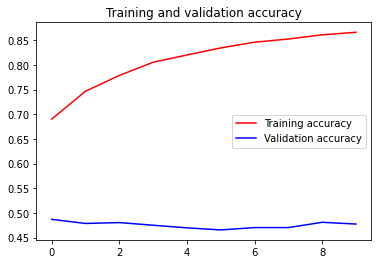

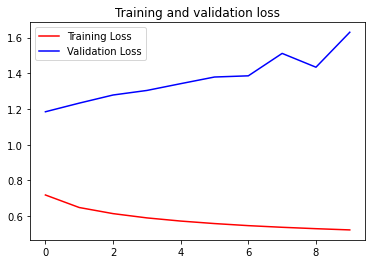

In [37]:
acc = train_accuracies
val_acc = val_accuracies
loss = train_losses
val_loss = val_losses

epochs = range(len(acc))                                                                                                                                                                                                                                                                                                                    

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [38]:
combined_model.load_state_dict(torch.load('2combined_model_sequence_.pth'))

<All keys matched successfully>

In [39]:
# test_data = create_delaunay_graph_data(test_df, test_labels)

# for i, data in enumerate(test_data):
#     data.filename = test_filenames[i]

In [40]:
# test_loader = DataLoader(test_data, batch_size=32)

In [41]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
def test_combined(gcn_loader, cnn_loader):
    combined_model.eval()
    video_outputs = {}
    video_labels = {}

    with torch.no_grad():
        for gcn_data, (cnn_features, cnn_labels, cnn_filenames) in zip(gcn_loader, cnn_loader):
            gcn_data = gcn_data.to(device)
            gcn_filenames = gcn_data.filename
            cnn_features = cnn_features.to(device)

            out = combined_model(gcn_data, cnn_features)
            softmax_out = out.softmax(dim=1).detach().cpu().numpy()  # Convert to probabilities and detach
            labels = gcn_data.y.cpu().numpy()

            # Aggregate predictions by video filename
            for filename, pred, label in zip(gcn_filenames, softmax_out, labels):
                video_id = filename.split('_')[0]  # Assuming filename format is `videoid_framenumber.jpg`
                if video_id not in video_outputs:
                    video_outputs[video_id] = np.zeros(pred.shape)
                    video_labels[video_id] = label
                video_outputs[video_id] += pred

    # Calculate video-level predictions
    final_preds = []
    final_labels = []

    for video_id in video_outputs:
        # Choose the class with the highest summed confidence score
        video_prediction = np.argmax(video_outputs[video_id])
        final_preds.append(video_prediction)
        final_labels.append(video_labels[video_id])

    return np.array(final_preds), np.array(final_labels)

test_preds, test_true = test_combined(test_loader, test_au_loader)
test_accuracy = np.sum(test_preds == test_true) / len(test_true)
print(test_accuracy)
# Ensure both loaders are synchronized

0.5089686098654709


In [42]:
report =  classification_report(test_true, test_preds ,target_names=[str(i) for i in range(num_classes)],zero_division=0)
print("\nClassification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.50      0.01      0.02        84
           2       0.51      0.80      0.62       900
           3       0.50      0.24      0.32       796

    accuracy                           0.51      1784
   macro avg       0.38      0.26      0.24      1784
weighted avg       0.50      0.51      0.46      1784



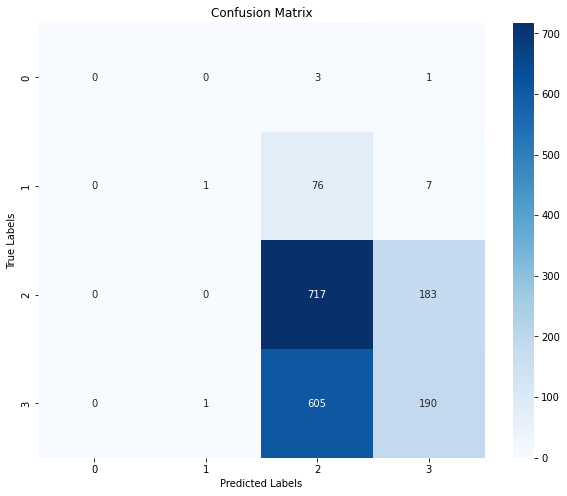

In [43]:
conf_matrix = confusion_matrix(test_true, test_preds)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(test_true), yticklabels=np.unique(test_true))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()